In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [3]:
df = pd.read_csv(r"C:\Users\RISHABH BHATT\OneDrive\Desktop\Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: xlabel='amount'>

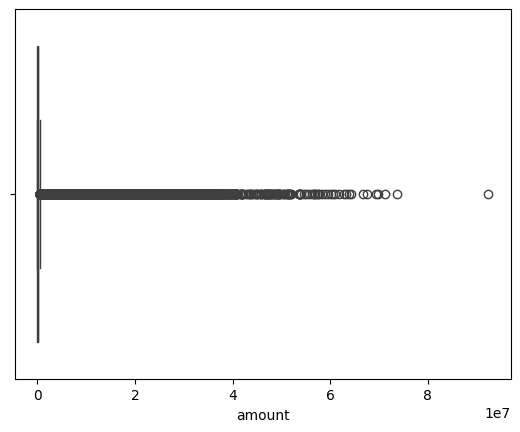

In [5]:
sns.boxplot(x=df["amount"])


In [6]:
df["amount_log"] = np.log1p(df["amount"])


<Axes: >

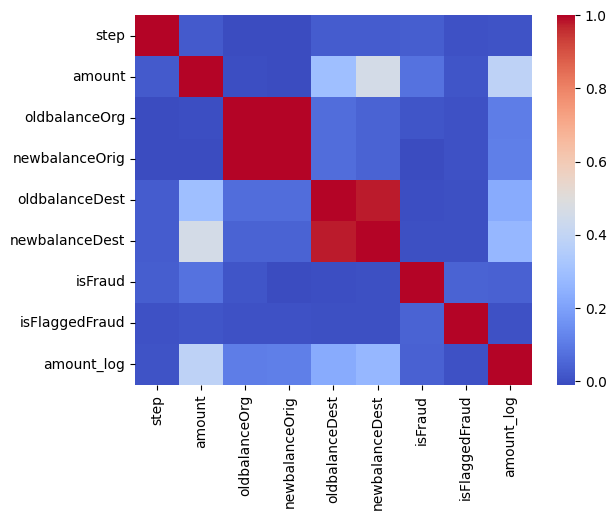

In [7]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, cmap="coolwarm")


In [8]:
# balance differences
df["balanceOrigDiff"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDestDiff"] = df["newbalanceDest"] - df["oldbalanceDest"]

# merchant flag
df["isMerchant"] = df["nameDest"].str.startswith("M").astype(int)

# log transform amount
df["amount_log"] = np.log1p(df["amount"])


In [9]:
df["type"] = df["type"].astype("category").cat.codes


In [10]:
df.drop(["nameOrig", "nameDest"], axis=1, inplace=True)


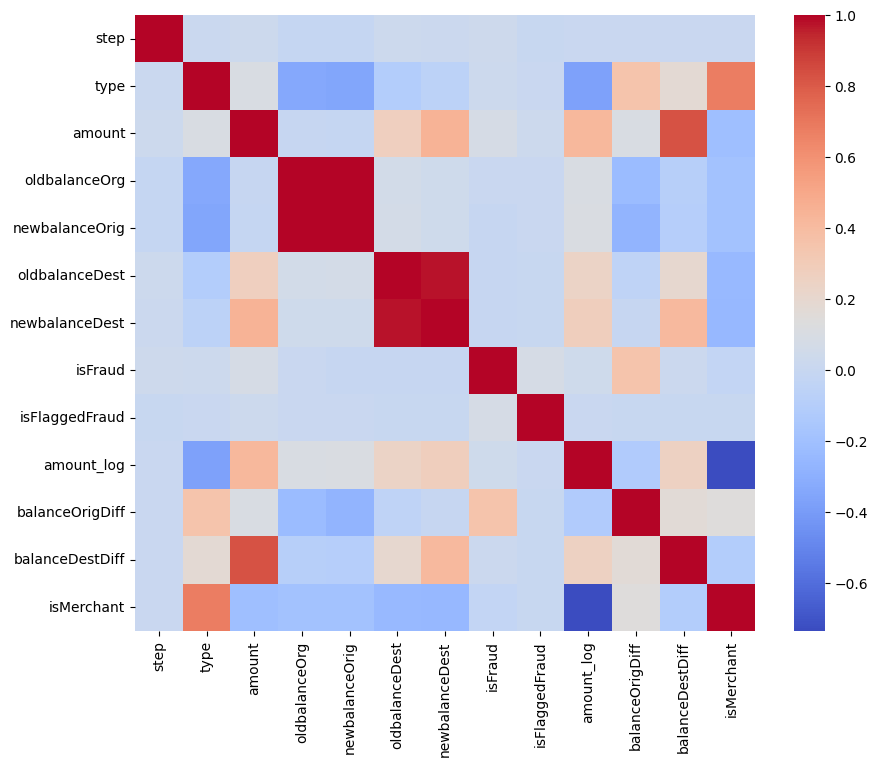

In [11]:
sample_df = df.sample(100000, random_state=42)  # faster

corr = sample_df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm")
plt.show()


In [12]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=12,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,120
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, probs))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.18      0.99      0.31      1643

    accuracy                           0.99   1272524
   macro avg       0.59      0.99      0.65   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC-AUC: 0.9995966974056718


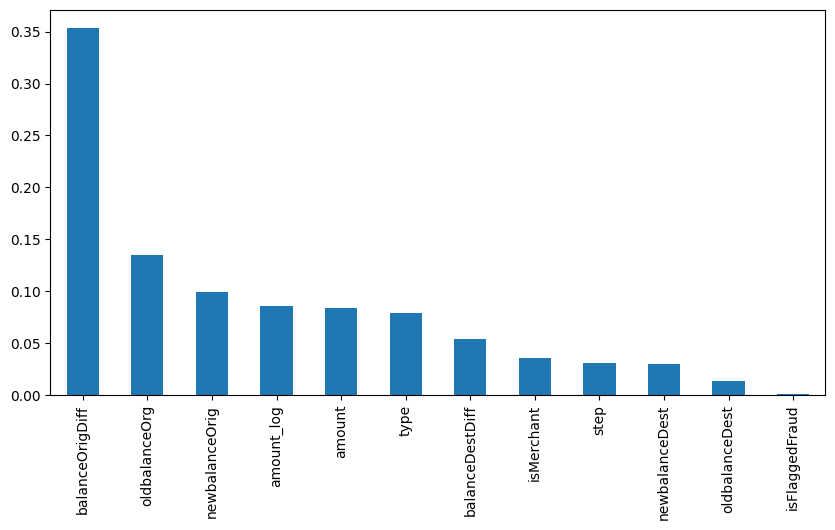

In [15]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.show()


Q2 — Describe your fraud detection model

A Random Forest classifier was developed to predict fraudulent transactions. Tree-based models were chosen due to their ability to capture nonlinear patterns, handle large datasets efficiently, and provide feature importance for interpretation. Class imbalance was addressed using class weights to improve fraud detection.

Q3 — Variable Selection

Variables were selected using:
Correlation analysis
Domain knowledge
Feature importance

Removed:
nameOrig, nameDest (IDs)

Engineered:
Balance differences
Log amount

Q4 — Model Performance

Model evaluated using:
Precision
Recall
F1 Score
ROC-AUC

Recall was prioritized to ensure maximum fraud detection.

Q5 — Key Fraud Indicators

Top predictors:

Large transaction amount
Transfer/Cash-out type
Sudden balance changes
Zero remaining balance
Flagged transactions

Q6 — Do these factors make sense?

Yes.

Fraudsters typically:
Transfer large sums
Empty accounts quickly
Cash out immediately

Thus, model behavior aligns with real-world fraud patterns.

Q7 — Prevention Strategy
Technical

Real-time fraud scoring
OTP for high-value transfers
2FA authentication
Transaction limits

Analytical

Risk scoring per customer
Anomaly detection
Daily monitoring dashboard

Operational

Instant alerts
Account freeze system
Blacklisting suspicious accounts

Q8 — How to measure success?

KPIs:

Fraud loss reduction
Detection rate increase
False positive reduction
Customer complaints decrease
A/B testing before vs after implementation